In [1]:
from google.cloud import bigquery

#client_bq = bigquery.Client.from_service_account_json("./credentials.json", project='charged-dialect-824')

In [2]:
def load_bq_data(_sql):
    _df = client_bq.query(_sql).to_dataframe()
    return _df


sql = """
SELECT *
FROM RicardoInterview.product_detection_training_data
"""

"""df_load = load_bq_data(sql)
len(df_load)
df_load.head()"""

'df_load = load_bq_data(sql)\nlen(df_load)\ndf_load.head()'

In [3]:
#df_load.shape

# Brief look at the sample dataset

In [4]:
import numpy as np
import pandas as pd

In [5]:
#raw=pd.read_csv("ricardo_data.csv", sep='|', index_col=0)
raw=df_load

In [6]:
from collections import defaultdict
d=defaultdict(list)
for index, product in raw.productType.iteritems(): d[product].append(index)

In [7]:
raw.head()

,articleId,title,subtitle,productType
0,-24471100344624315,Metal Hurlant,NaN,magazine
1,-4941423510709663049,Mikrophone,NaN,sound_card
2,6882901079846443092,Sound Blaster Audigy CREATIVE,Soundkarte für PC,sound_card
3,-309151326745158426,"Umlenkrolle Forst, extra leicht",100 kn / 10 Tonnen,winch
4,-3342786788349504714,MATSCHFACH MORITZ SPEZIAL,*GRATIS LIEFERUNG*,sandpit


In [8]:
y=np.array(raw.productType)
classes=np.unique(y)
print("{} labeled samples for {} (!) target classes".format(len(y), len(classes)))

37567 labeled samples for 383 (!) target classes


A histogram of the frequencies of each product type in the sample set allows us to quickly confirm:
1. whether there are imbalannces in the representation of target classes: Rather not, as all classes are represented by 50-99 samples, i.e. not even a single order of magnitude apart - this is quite a balanced set for a multiclass classifier.
2. whether there are serious outliers or even misspells etc in the taxonomy: no, the Product type column is clean

AxesSubplot(0.125,0.125;0.775x0.755)


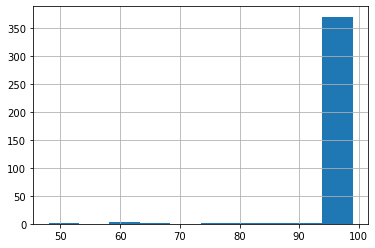

In [9]:
print(raw.productType.value_counts().hist()) # all classes represented n times, where 48<n<99

In [10]:
#Indeed:
raw.productType.value_counts().sort_values()[:3], raw.productType.value_counts().sort_values()[-3:]

(marble        48
 dump_truck    52
 jukebox       60
 Name: productType, dtype: int64,
 smartwatch     99
 plant          99
 coffee_mill    99
 Name: productType, dtype: int64)

# Initial transformation to a BoF

Examining **title & subtitle as a single feature string** (after addressing empty subtitles): the rough(!) assumption is that the subtitles are not strictly inferior in informativeness for the target class to the main titles, as Ricardo users are not prompted so when entering. This hypothesis is worth examining, but not now.

In [11]:
raw = raw.replace(np.nan,'', regex=True)
raw["descr"]=raw.title+" "+raw.subtitle

In [12]:
all_of_it = raw.descr.str.cat(sep=' ')
print("The entire training corpus combined consists of", len(all_of_it), 'total characters in', len(all_of_it.split(" ")), 'total words')

The entire training corpus combined consists of 1669640 total characters in 255518 total words


**Basic Bag-of-words vectorization of the assembled title strings and subsequent further transformation of the vocabulary:**

In [13]:
import re
import spacy  # for lemmatization
import nltk   # for word stemming
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import bof_utils
lexicon = spacy.load("de_core_news_sm")
# lexicon = spacy.load("de")
bof_utils.nlp=lexicon

nltk.download('stopwords')
nltk.download('punkt')
nltk_stopwords_de = nltk.corpus.stopwords.words('german')
spacy_stopwords_de = spacy.lang.de.stop_words.STOP_WORDS

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [14]:
print(bof_utils.lemmatizer("jawohl, dieses Auto gehört mir, warum nicht, mein Mann, haben Sie auch ein gleiches?"))

['jawohl', ',', 'dies', 'Auto', 'hören', 'sich', ',', 'warum', 'nicht', ',', 'meinen', 'Mann', ',', 'haben', 'ich', 'auch', 'einen', 'gleich', '?']


In [15]:
print(bof_utils.de_blob_lemmatizer("jawohl, dieses Auto gehört mir, warum nicht, mein Mann, haben Sie auch ein gleiches"))

['jawohl', 'dies', 'Auto', 'gehören', 'mir', 'warum', 'nicht', 'mein', 'Mann', 'haben', 'Sie', 'auch', 'ein', 'gleiches']


In [16]:
_, bag= bof_utils.BoF(data=raw.descr)

Vocabulary size: 43977, training set size: 37567 samples * 43977 features
# of tokens automatically excluded from the vocabulary: 0


In [17]:
vocab = bag.get_feature_names()
corpus_vocab_count_dict={w:c for (w,c) in zip(vocab, bag.transform([all_of_it]).toarray()[0])}
sorted_corpus_count=sorted(corpus_vocab_count_dict.items(), key=lambda x: x[1])

In [18]:
sorted_corpus_count[-8:] # potentially uninformative, too frequent tokens (mostly German stopwords) at the top of the vocabulary pile

[('in', 969),
 ('gr', 1008),
 ('von', 1036),
 ('cm', 1201),
 ('und', 1418),
 ('neu', 1429),
 ('für', 2094),
 ('mit', 3646)]

In [19]:
sorted_corpus_count[:8] # potentially uninformative, too infrequent tokens at the bottom of the vocabulary pile

[('0018m2', 1),
 ('002', 1),
 ('003160', 1),
 ('0041', 1),
 ('0057', 1),
 ('00687', 1),
 ('006r01264', 1),
 ('008r13021', 1)]

In [20]:
variants=defaultdict(lambda: defaultdict(dict))
variants["default_vectorizer"]["vectorizers"]=bag

**Slightly more sophisticated corpus representation - dropping German stopwords:**

**ToDo**: Would be intriguing to build a language recognition pipeline based on this:
https://data-science-blog.com/blog/2018/11/12/language-detecting-with-sklearn-by-determining-letter-frequencies/
to treat titles written in French, English, German & Italian accordingly regarding stopwords/lemmatization.

In [21]:
stopwords=spacy_stopwords_de

_,variants["stopwords"]["vectorizers"]= bof_utils.BoF(data=raw.descr, stop_words=stopwords)

Vocabulary size: 43683, training set size: 37567 samples * 43683 features
# of tokens automatically excluded from the vocabulary: 0
# of stopwords that were effectively excluded : 543


**Rescaling the data with tf-idf:**

In [22]:
_, variants["w_tfidf"]["vectorizers"]= bof_utils.BoF(data=raw.descr, tfidf= True, stop_words=stopwords)

Vocabulary size: 43683, training set size: 37567 samples * 43683 features
# of tokens automatically excluded from the vocabulary: 0
# of stopwords that were effectively excluded : 543


**and force-excluding too frequent/infrequent terms from the vocabulary:**

In [23]:
_, variants["w_tfidf_min2_max100"]["vectorizers"]= bof_utils.BoF(data=raw.descr, tfidf= True,  min_df=2, max_df=100, stop_words=stopwords)

Vocabulary size: 16576, training set size: 37567 samples * 16576 features
# of tokens automatically excluded from the vocabulary: 27107
# of stopwords that were effectively excluded : 543


**...and enriching the feature set with some n-grams:**

In [24]:
variant="w_tfidf_ngram_3"

_, variants["w_tfidf_ngram_3"]["vectorizers"]= bof_utils.BoF(data=raw.descr, tfidf= True, min_df=2, ngram_range=(1,3), stop_words=stopwords)

Vocabulary size: 41058, training set size: 37567 samples * 41058 features
# of tokens automatically excluded from the vocabulary: 226585
# of stopwords that were effectively excluded : 543


**Last, trying lemmatization on the vocabulary**

In [25]:
for custom_tokenizer in [bof_utils.lemmatizer]:
    variant=custom_tokenizer.__name__+"_w_tfidf"
    _,variants[variant]["vectorizers"]= bof_utils.BoF(data=raw.descr,custom_tokenizer=custom_tokenizer, 
                          tfidf= True, min_df=2, stop_words=custom_tokenizer(", ".join(stopwords)))

/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"
/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['einigen', 'gleich', 'heiß', 'lieben', 'vergehen', 'wahr'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Vocabulary size: 16613, training set size: 37567 samples * 16613 features
# of tokens automatically excluded from the vocabulary: 31327
# of stopwords that were effectively excluded : 332


# Trying some (basic) Classifiers on these BoF representations:

 
 
**Observe the sparse nature of the bag-of-words data representation, which pretty much dictates the families of models applicable:**

In [26]:
X=variants["w_tfidf_min2_max100"]["vectorizers"].transform(raw.descr)
print(repr(X))

<37567x16576 sparse matrix of type '<class 'numpy.float64'>'
	with 125785 stored elements in Compressed Sparse Row format>


***Accuracy of random guessing:*** 

In [27]:
print("\n{:.2f} % ".format(100/len(classes)))


0.26 % 


 
 
... I 'd better beat this... :P
 
 

In [28]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB
from sklearn.metrics import classification_report, f1_score

In [29]:
import nested_x_val
score_metric="f1_macro"

models=[MultinomialNB(alpha=.1) , SGDClassifier(random_state=101, loss="modified_huber")] # LogisticRegression(C=1., warm_start=True, class_weight='balanced'),
for variant in variants.keys():
    print("\nWith data from {}\n(vocabulary size: {}):".format(variant,len(variants[variant]["vectorizers"].get_feature_names())))
    _=nested_x_val.model_mvp(models,
                            variants[variant]["vectorizers"].transform(raw.descr),y, 
                            n_splits=3, n_jobs=1, score_metric=score_metric, random_state=101)


With data from default_vectorizer
(vocabulary size: 43977):
                                          train vs. test
f1_macro of default        MultinomialNB:  0.98     0.67
                                          train vs. test
f1_macro of default        SGDClassifier:  0.99     0.70

With data from stopwords
(vocabulary size: 43683):
                                          train vs. test
f1_macro of default        MultinomialNB:  0.98     0.68
                                          train vs. test
f1_macro of default        SGDClassifier:  0.99     0.71

With data from w_tfidf
(vocabulary size: 43683):
                                          train vs. test
f1_macro of default        MultinomialNB:  0.99     0.71
                                          train vs. test
f1_macro of default        SGDClassifier:  0.99     0.75

With data from w_tfidf_min2_max100
(vocabulary size: 16576):
                                          train vs. test
f1_macro of default        Multino

**Some further conclusions from the prototyping:**
1. ... waaaay overfitting, at this point - mode training data will smoothen the BoF-tf-idf vector and increase accuracy
2. the **w_tfidf_min2_max100** settings for the BoF vectorization seem the best early choice: competitive accuracy but a severely downsized vocabulary size (-60% of the rest)


# Hyperparameter tuning of estimators on chosen representation

**i.  Choosing between the SVC and the NB**
 
**ii. Simultaneously applying a basic (cross-validated) grid search for optimal settings on their main regularization hyperparameters**

In [30]:
NB_alpha_range=[0.01,0.1,1.,10.]
SVM_alpha_range=[0.00001,0.0001,0.001,0.01]
max_df_range=[50,100]
min_df_range=[2, 3]

**For the sake of validation of our choice of Bag-of-words specifics, we will actually run the hyper-tuning grid search on the entire pipeline of {data transformation --> classification}:**

In [31]:
e2e_pipe= Pipeline([('vectorizer',CountVectorizer()),('classifier', MultinomialNB())])
pipe_grid= [{"classifier":[MultinomialNB()], "vectorizer": [CountVectorizer(), TfidfVectorizer()],
            "classifier__alpha": NB_alpha_range, "vectorizer__max_df":max_df_range,"vectorizer__min_df":min_df_range, "vectorizer__stop_words":[None, stopwords]},
            {"classifier":[SGDClassifier(random_state=101, loss="modified_huber")], "vectorizer": [CountVectorizer(), TfidfVectorizer()],
            "classifier__alpha": SVM_alpha_range,"vectorizer__max_df":max_df_range,"vectorizer__min_df":min_df_range, "vectorizer__stop_words":[None, stopwords]}]

best_e2e = nested_x_val.nested_x_val_grid_search(e2e_pipe, raw.descr, y, pipe_grid, show_me_params= False, score_metric=score_metric)

Average f1_macro on the test set: 0.718
Average f1_macro score on the train set: 0.951


**For a more comprehensive review of the final predictor (end-to-end pipeline), we can review a classification report:**

In [32]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(raw.descr,y,stratify=y, test_size=0.2,random_state=102)
y_pred=best_e2e.fit(X_train,y_train).predict(X_test)
report=classification_report(y_test, y_pred, output_dict=True, target_names=best_e2e.classes_)
for metric in ['precision', 'recall', 'f1-score']: print("Trained model average {:>10} : {:>7.2f}".format(metric,report['macro avg'][metric]))

Trained model average  precision :    0.76
Trained model average     recall :    0.72
Trained model average   f1-score :    0.73


As expected for a very balanced training set, the model appears well calibrated, as precision & recall are aligned with the f1-score, and we can be confident of equivalent confidence when generalizing to new data.
**The model is ready to be deployed**.

In [33]:
# re-fitting the best model on the entire available labelled set:
final=best_e2e.fit(raw.descr,y)

In [34]:
print("Our prototype vectorizer:\n\n",final["vectorizer"])

Our prototype vectorizer:

 TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=100, max_features=None,
                min_df=2, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)


In [35]:
print("Our prototype classifier:\n\n",final["classifier"])

Our prototype classifier:

 SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='modified_huber',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=101, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)


# Ready for top-5 Product types predictions!

In [36]:
an_example_title="Blaster Moritz Mikrophone Batman Batman Woot 10 100 Dimitrios Batman"

In [37]:
X_example=final["vectorizer"].transform([an_example_title])
vocab_in_example=list(X_example.nonzero()[1])   # remember, the sample is of sparse matrix type, NOT a dense array or list!
vocab=final["vectorizer"].get_feature_names()
print("The BoF representation of the to-be-classified example:")
print({vocab[i]:X_example[0, i] for i in vocab_in_example})

The BoF representation of the to-be-classified example:
{'moritz': 0.27393352620603156, 'mikrophone': 0.29401675926121484, 'blaster': 0.24597129091757353, 'batman': 0.8820502777836445}


In [38]:
probas=final["classifier"].predict_proba(X_example)[0]
top5=np.argsort(probas)[-5:]
results=["product_type: '{}' with probability: {:.2} ".format(x,y) for x,y in zip(reversed(classes[top5]),reversed(probas[top5]))]
print('title: "{}" \n\ntop_5_results:\n{}'.format(an_example_title, str(results)))

title: "Blaster Moritz Mikrophone Batman Batman Woot 10 100 Dimitrios Batman" 

top_5_results:
["product_type: 'bathrobe' with probability: 0.38 ", "product_type: 'sound_card' with probability: 0.26 ", "product_type: 'comic_book' with probability: 0.075 ", "product_type: 'video_game_console' with probability: 0.056 ", "product_type: 'sandpit' with probability: 0.054 "]


In [39]:
# this all needs to be packaged as a single output function for the flask service:
import json
def predict_top5(doc, classifier):
    top5=np.argsort(classifier.predict_proba(doc)[0])[-5:]
        
    #requested JSON elements:
    title=doc
    top_5_results=[{"product_type": x, "score": "{:.4f}".format(y)} for (x,y) in zip(reversed(classes[top5]),reversed(probas[top5]))]
    product_type=classes[top5][-1]
    return json.dumps({"title": title, "top_5_results": top_5_results, "product_type": product_type}, indent=3)


In [40]:
print(predict_top5(["Blaster Moritz Mikrophone Batman Batman Woot 10 100 Dimitrios Batman"], final))

{
   "title": [
      "Blaster Moritz Mikrophone Batman Batman Woot 10 100 Dimitrios Batman"
   ],
   "top_5_results": [
      {
         "product_type": "bathrobe",
         "score": "0.3759"
      },
      {
         "product_type": "sound_card",
         "score": "0.2574"
      },
      {
         "product_type": "comic_book",
         "score": "0.0750"
      },
      {
         "product_type": "video_game_console",
         "score": "0.0563"
      },
      {
         "product_type": "sandpit",
         "score": "0.0544"
      }
   ],
   "product_type": "bathrobe"
}


In [41]:
import pickle
with open('trained.pkl', 'wb') as f: pickle.dump(final, f)  
    # the BoF transformer is shipped over to the Flask service also as a component of the pipelined predictor

In [43]:
def wrapper(classifier):
    def top5(doc):
        top5=np.argsort(classifier.predict_proba(doc)[0])[-5:]
        
        #requested JSON elements:
        title=doc
        top_5_results=[{"product_type": x, "score": "{:.4f}".format(y)} for (x,y) in zip(reversed(classes[top5]),reversed(probas[top5]))]
        product_type=classes[top5][-1]
        return json.dumps({"title": title, "top_5_results": top_5_results, "product_type": product_type}, indent=3)
    return top5
print(wrapper(final)(["Blaster Moritz Mikrophone"]))

{
   "title": [
      "Blaster Moritz Mikrophone"
   ],
   "top_5_results": [
      {
         "product_type": "sound_card",
         "score": "0.2574"
      },
      {
         "product_type": "sandpit",
         "score": "0.0544"
      },
      {
         "product_type": "vhs",
         "score": "0.0416"
      },
      {
         "product_type": "voucher",
         "score": "0.0513"
      },
      {
         "product_type": "bottle",
         "score": "0.0192"
      }
   ],
   "product_type": "sound_card"
}
